In [1]:
from pycaret.classification import *
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
bohun= pd.read_csv('newbohun.csv', encoding='cp949')
display(bohun.head())

,환자번호,환자명,생년월일,성별,조직형,"cell type adc 1, sqcc 2, others 3",PET1 검사날짜,age,"pathologic CR a, 1, 0","pathologic CR b, 1, 0",viable tumor %,"PERCIST criteria CMR 0, PMR 1, SMD 2, PMD 3","PERCIST response responder 1, non responder 0",Stage 7th,TNM 7th,stage 8th,TNM 8th,Second angular moment Cooccurance PET1,Contrast Cooccurance PET1,Entropy Cooccurance PET1,Homogeneity Cooccurance PET1,Dissimilarity Cooccurance PET1,Inverse difference moment Cooccurance PET1,Short run emphasis Voxel-alignment PET1,Long run emphasis Voxel-alignment PET1,Intensity variability Voxel-alignment PET1,Run-length variability Voxel-alignment PET1,Run percentage Voxel-alignment PET1,Low-intensity run emphasis Voxel-alignment PET1,High-intensity run emphasis Voxel-alignment PET1,Low-intensity short-run emphasis Voxel-alignment PET1,High-intensity short-run emphasis Voxel-alignment PET1,Low-intensity long-run emphasis Voxel-alignment PET1,High-intensity long-run emphasis Voxel-alignment PET1,Coarseness Neighborhood intensity-difference PET1,Contrast Neighborhood intensity-difference PET1,Busyness Neighborhood intensity-difference PET1,Complexity Neighborhood intensity-difference PET1,Strength Neighborhood intensity-difference PET1,Short-zone emphasis Intensity-size-zone PET1,Large-zone emphasis Intensity-size-zone PET1,Intensity variability Intensity-size-zone PET1,Size-zone variability Intensity-size-zone PET1,Zone percentage Intensity-size-zone PET1,Low-intensity zone emphasis Intensity-size-zone PET1,High-intensity zone emphasis Intensity-size-zone PET1,Low-intensity short-zone emphasis Intensity-size-zone PET1,High-intensity short-zone emphasis Intensity-size-zone PET1,Low-intensity large-zone emphasis Intensity-size-zone PET1,High-intensity large-zone emphasis Intensity-size-zone PET1,Second angular moment Normalized Cooccurance PET1,Contrast Normalized Cooccurance PET1,Entropy Normalized Cooccurance PET1,Homogeneity Normalized Cooccurance PET1,Dissimilarity Normalized Cooccurance PET1,Inverse difference moment Normalized Cooccurance PET1,Correlation Cooccurance PET1,Minimum SUV SUV statistics PET1,Maximum SUV SUV statistics PET1,Mean SUV SUV statistics PET1,SUV Variance SUV statistics PET1,SUV SD SUV statistics PET1,SUV Skewness SUV statistics PET1,SUV Kurtosis SUV statistics PET1,SUV bias-corrected Skewness SUV statistics PET1,SUV bias-corrected Kurtosis SUV statistics PET1,TLG SUV statistics PET1,Tumor volume SUV statistics PET1,Entropy SUV statistics PET1,SULpeak SUV statistics PET1,Max spectrum Texture Spectrum PET1,Black-white symmetry Texture Spectrum PET1,Coarseness Texture Feature Coding PET1,Homogeneity Texture Feature Coding PET1,Mean convergence Texture Feature Coding PET1,Variance Texture Feature Coding PET1,Second angular moment Texture Feature Coding Cooccurance PET1,Contrast Texture Feature Coding Cooccurance PET1,Entropy Texture Feature Coding Cooccurance PET1,Homogeneity Texture Feature Coding Cooccurance PET1,Intensity Texture Feature Coding Cooccurance PET1,Inverse difference moment Texture Feature Coding Cooccurance PET1,Code Entropy Texture Feature Coding Cooccurance PET1,Code Similarity Texture Feature Coding Cooccurance PET1,Small number emphasis Neighboring Gray Level Dependence PET1,Large number emphasis Neighboring Gray Level Dependence PET1,Number nonuniformity Neighboring Gray Level Dependence PET1,Second moment Neighboring Gray Level Dependence PET1,Entropy Neighboring Gray Level Dependence PET1,Second angular moment Cooccurance PET2,Contrast Cooccurance PET2,Entropy Cooccurance PET2,Homogeneity Cooccurance PET2,Dissimilarity Cooccurance PET2,Inverse difference moment Cooccurance PET2,Short run emphasis Voxel-alignment PET2,Long run emphasis Voxel-alignment PET2,Intensity variability Voxel-alignment PET2,Run-length variability Voxel-alignment PET2,Run percentage Voxel-alignment PET2,Low-intensity run emphasis Voxel-alignment PET2,High-intensity run emphasis Voxel-alignment PET2,Low-intensity short-run emphasis Voxel-alignment

In [3]:
nrow = bohun.shape[0] # 환자 명수 데이터 양(row)
ncol = bohun.shape[1] # 피쳐 갯수(column)
print('nrow: %d' % nrow, 'ncol: %d' % ncol )

nrow: 218 ncol: 168


In [4]:
feature_columns_a= list(bohun.columns[17:89]) ##pet1 feature   
len(feature_columns_a) 

72

In [5]:
feature_columns_b= list(bohun.columns[89:161]) ## pet2 feature
len(feature_columns_b)

72

In [6]:
x_columns_1 = feature_columns_a    ## 72개 주요 pet1 feature 반영 
x_columns_2 = feature_columns_a + feature_columns_b ## 144개 변수 pet1+et2 
x_columns_3=feature_columns_b
bohun_train_1=bohun[x_columns_1] ## dataframe 형태 pet1 변수만 반영 <72개>
bohun_train_2=bohun[x_columns_2] ## dataframe 형태 pet1,pet2 변수 모두 반영 <144개> 
bohun_train_3=bohun[x_columns_3] ## dataframe 형태 pet2 변수만 반영 <72개> 

In [7]:
bohun_y_train_1=bohun[bohun.columns[8]] # pathologic CR a
bohun_y_train_2=bohun[bohun.columns[9]] # pathologic CR b

## 변수 스케일링

In [8]:
from sklearn.preprocessing import StandardScaler
standardScaler = StandardScaler()

In [9]:
## bohun_train_1 (72개 pet1 기본 변수만 적용한 트레인 셋 스케일 조정)
bohun_train_1[bohun.columns[17:89]] = standardScaler.fit_transform(bohun_train_1[bohun.columns[17:89]])
bohun_train_2[bohun.columns[17:89]]=standardScaler.fit_transform(bohun_train_2[bohun.columns[17:89]])
bohun_train_2[bohun.columns[89:161]]=standardScaler.fit_transform(bohun_train_2[bohun.columns[89:161]])
bohun_train_3[bohun.columns[89:161]]=standardScaler.fit_transform(bohun_train_3[bohun.columns[89:161]])

## SMOTE 적용

In [83]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from collections import Counter
from matplotlib import pyplot

In [139]:
# 모델설정
sm=SMOTE(random_state=0)
# train데이터를 넣어 복제함
X_resampled_1, y_resampled_1 = sm.fit_sample(bohun_train_1,bohun_y_train_1)

In [95]:
def count_and_plot(y): 
    counter = Counter(y)
    for k,v in counter.items():
        print('Class=%d, n=%d (%.3f%%)' % (k, v, v / len(y) * 100))
    pyplot.bar(counter.keys(), counter.values())
    pyplot.show()
    

Class=1, n=192 (50.000%)
Class=0, n=192 (50.000%)


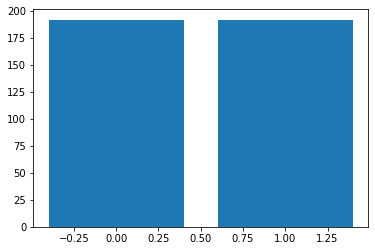

In [96]:
count_and_plot(y_resampled_1)

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5,criterion="gini",n_estimators=600, random_state=0)
clf.fit(X_resampled_1, y_resampled_1)

RandomForestClassifier(max_depth=5, n_estimators=600, random_state=0)

In [51]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, random_state=42)

In [61]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,auc
from sklearn.model_selection import cross_val_score
model_metrics = {}

In [69]:
from sklearn.utils import shuffle
X_s, y_s = shuffle(X_resampled_1,y_resampled_1,random_state=12)

In [100]:
model_metrics['randomforest cv: Accuracy'] = round(np.mean(cross_val_score(clf,X_resampled_1, y_resampled_1,cv=kfold,n_jobs=1,scoring='accuracy')),3)
model_metrics['randomforest cv: Precision'] =round(np.mean(cross_val_score(clf,X_resampled_1, y_resampled_1,cv=kfold,n_jobs=1,scoring='precision')),3)
model_metrics['randomforest cv: Recall'] = round(np.mean(cross_val_score(clf,X_resampled_1, y_resampled_1,cv=kfold,n_jobs=1,scoring='recall')),3)
model_metrics['randomforest cv: F1 score'] =round(np.mean(cross_val_score(clf,X_resampled_1, y_resampled_1,cv=kfold,n_jobs=1,scoring='f1')),3)
model_metrics['randomforest cv: AUC']= round(np.mean(cross_val_score(clf,X_s, y_s,cv=kfold,n_jobs=1,scoring='roc_auc')),3)
#model_metrics['randomforest cv: AUC'] =round(np.mean(cross_val_score(clf,X_resampled_1, y_resampled_1,cv=kfold,n_jobs=1,scoring='roc_auc')),3)
pd.DataFrame([model_metrics])

,randomforest cv: Accuracy,randomforest cv: Precision,randomforest cv: Recall,randomforest cv: F1 score,randomforest cv: AUC
0,0.751,0.553,0.552,0.549,0.936


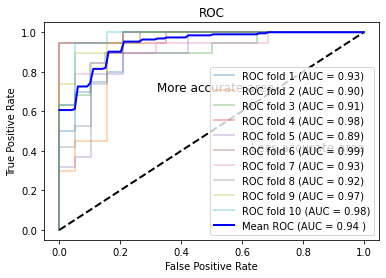

In [103]:
from sklearn.model_selection import StratifiedKFold
x=X_resampled_1
y=y_resampled_1


cv = StratifiedKFold(n_splits=10,shuffle=False)
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(x,y):
    prediction = clf.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1
    
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

In [104]:
train_1, test_1, train_y_1, test_y_1 = train_test_split(X_resampled_1,y_resampled_1, test_size = 0.3, random_state =2) # traindata, testdata split 비율 7:3
print(train_1.shape, test_1.shape, train_y_1.shape, test_y_1.shape) # 데이터 shape 확인

(268, 72) (116, 72) (268,) (116,)


In [105]:
random_forest_model1 = RandomForestClassifier(n_estimators = 600, # 900번 추정
                                             max_depth = 5, # 트리 최대 깊이 5
                                             random_state = 40) # 시드값 고정
model1 = random_forest_model1.fit(train_1, train_y_1) # 학습 진행
predict1 = model1.predict(test_1) # 평가 데이터 예측
print("Accuracy: %.2f" % (accuracy_score(test_y_1, predict1) * 100), "%") # 정확도 % 계산

Accuracy: 82.76 %


In [113]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,auc
 ##재현율과 정밀도가 비슷할수록 f1 score는 높아짐 (the harmonic mean of recall and precision)
model_metrics = {}
model_metrics['randomforest: Accuracy'] = accuracy_score(test_y_1, predict1) 
model_metrics['randomforest: Precision'] = precision_score(test_y_1, predict1)
model_metrics['randomforest: Recall'] = recall_score(test_y_1, predict1) 
model_metrics['randomforest: F1 score'] =f1_score(test_y_1, predict1) 
model_metrics['randomforest: AUC'] =roc_auc_score(test_y_1,clf.predict_proba(test_1)[:, 1])
pd.DataFrame([model_metrics])

,randomforest: Accuracy,randomforest: Precision,randomforest: Recall,randomforest: F1 score,randomforest: AUC
0,0.827586,0.768116,0.929825,0.84127,0.999405


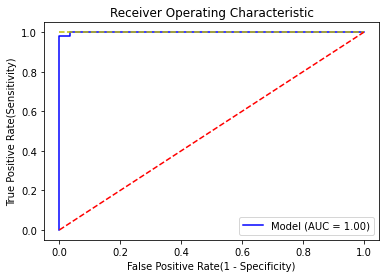

In [110]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y_1, clf.predict_proba(test_1)[:, 1])
roc_auc = roc_auc_score(test_y_1,clf.predict_proba(test_1)[:, 1])
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate(1 - Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate, true_positive_rate, 'b', label='Model (AUC = %0.2f)'% roc_auc)
plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')

plt.legend(loc='lower right')
plt.show()

In [140]:
# 모델설정
sm=SMOTE(random_state=0)
# train데이터를 넣어 복제함
X_resampled_2, y_resampled_2 = sm.fit_sample(bohun_train_2,bohun_y_train_1)

Class=1, n=192 (50.000%)
Class=0, n=192 (50.000%)


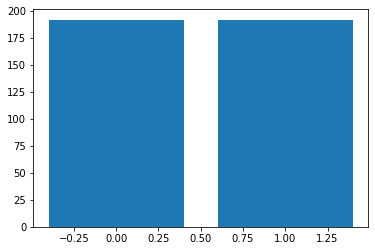

In [141]:
count_and_plot(y_resampled_2)

In [142]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5,criterion="gini",n_estimators=600, random_state=29)
clf.fit(X_resampled_2, y_resampled_2)

RandomForestClassifier(max_depth=5, n_estimators=600, random_state=29)

In [143]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, random_state=58)

In [118]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,auc
from sklearn.model_selection import cross_val_score
model_metrics = {}

In [119]:
from sklearn.utils import shuffle
X_s, y_s = shuffle(X_resampled_2,y_resampled_2,random_state=12)

In [120]:
model_metrics['randomforest cv: Accuracy'] = round(np.mean(cross_val_score(clf,X_resampled_2, y_resampled_2,cv=kfold,n_jobs=1,scoring='accuracy')),3)
model_metrics['randomforest cv: Precision'] =round(np.mean(cross_val_score(clf,X_resampled_2, y_resampled_2,cv=kfold,n_jobs=1,scoring='precision')),3)
model_metrics['randomforest cv: Recall'] = round(np.mean(cross_val_score(clf,X_resampled_2, y_resampled_2,cv=kfold,n_jobs=1,scoring='recall')),3)
model_metrics['randomforest cv: F1 score'] =round(np.mean(cross_val_score(clf,X_resampled_2, y_resampled_2,cv=kfold,n_jobs=1,scoring='f1')),3)
model_metrics['randomforest cv: AUC']= round(np.mean(cross_val_score(clf,X_s, y_s,cv=kfold,n_jobs=1,scoring='roc_auc')),3)
#model_metrics['randomforest cv: AUC'] =round(np.mean(cross_val_score(clf,X_resampled_1, y_resampled_1,cv=kfold,n_jobs=1,scoring='roc_auc')),3)
pd.DataFrame([model_metrics])

,randomforest cv: Accuracy,randomforest cv: Precision,randomforest cv: Recall,randomforest cv: F1 score,randomforest cv: AUC
0,0.848,0.573,0.563,0.567,0.965


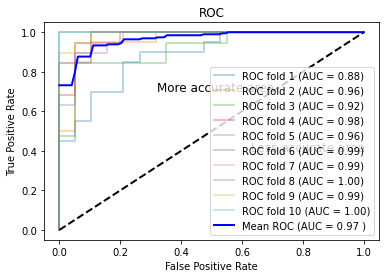

In [121]:
from sklearn.model_selection import StratifiedKFold
x=X_resampled_2
y=y_resampled_2


cv = StratifiedKFold(n_splits=10,shuffle=False)
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(x,y):
    prediction = clf.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1
    
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

## 상위 변수 importance 기준 정리 <PET 1,2>

In [144]:
clf.feature_importances_  ## 모델링 feature importance 값들 확인 

array([7.14348016e-03, 5.58048705e-03, 7.99680025e-03, 1.13403683e-02,
       4.48657768e-03, 1.49107032e-02, 4.68041321e-03, 3.68809697e-03,
       3.36058083e-03, 4.17700205e-03, 4.31341946e-03, 2.84284395e-03,
       5.00742181e-03, 3.88873471e-03, 4.25062218e-03, 3.24989626e-03,
       7.93482853e-03, 3.01619169e-03, 2.89497243e-03, 2.56768526e-03,
       3.21361256e-03, 3.39006796e-03, 4.47150596e-03, 6.18949426e-03,
       5.59169994e-03, 5.65258516e-03, 1.04382341e-02, 3.85091109e-03,
       3.77467101e-03, 3.09620743e-03, 4.79341400e-03, 4.11315176e-03,
       5.32904770e-03, 8.75325352e-03, 7.03473046e-03, 7.69806422e-03,
       6.52060059e-03, 5.39753773e-03, 4.55141629e-03, 9.68000110e-03,
       6.20076532e-03, 3.56796728e-03, 4.09997993e-03, 4.83481754e-03,
       4.07310369e-03, 1.44374720e-02, 7.20954996e-03, 8.79270619e-03,
       6.60415086e-03, 9.74959530e-03, 1.28426600e-02, 5.24951132e-03,
       4.93698064e-03, 3.33531399e-03, 2.41009065e-03, 6.27937644e-03,
      

In [147]:
list_column = []   ##컬럼 리스트
list_fi = []   ##featureimportance 리스트
for i,j in zip(X_resampled_2.columns,clf.feature_importances_):
    list_column.append(i)
    list_fi.append(j)

Text(0.5, 0, 'Relative Importance')

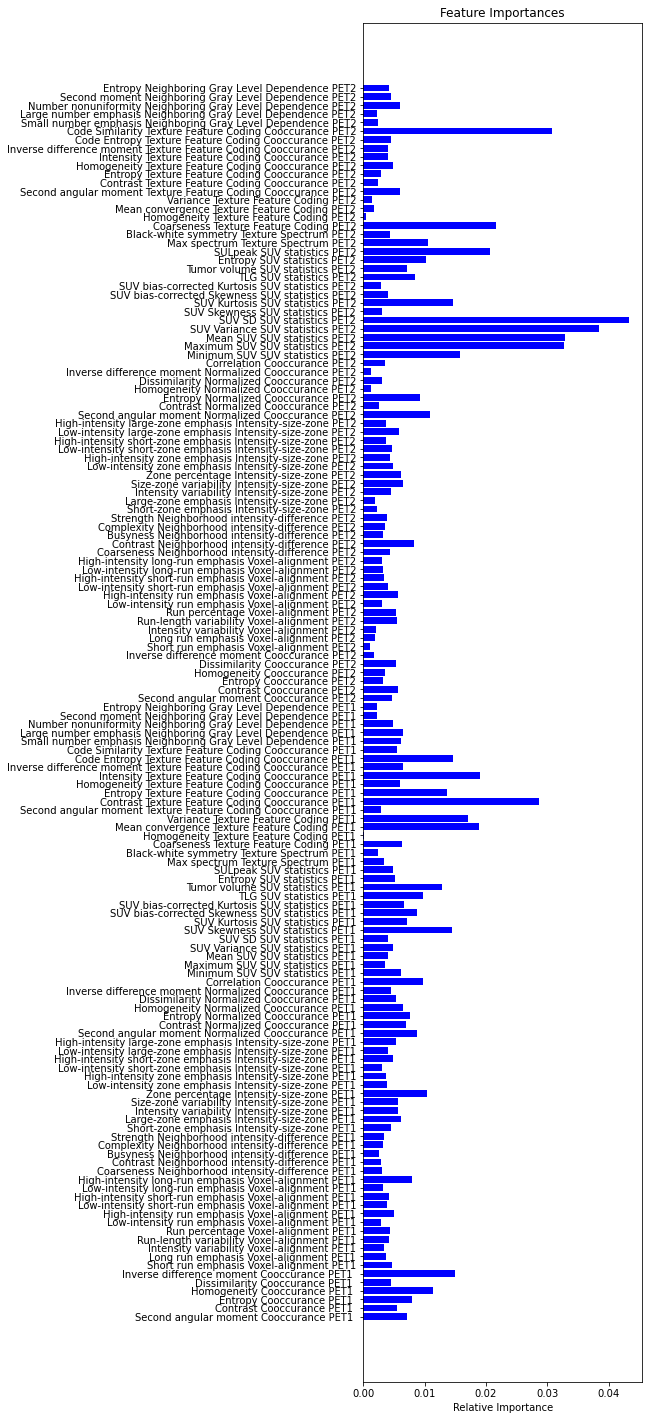

In [188]:
## feature importance 시각화 
plt.rcParams["figure.figsize"] = (5,25)
plt.figure(1)
plt.title('Feature Importances')
plt.barh(range(len(list_fi)), list_fi, color='b', align='center')
plt.yticks(range(len(list_column)), list_column)
plt.xlabel('Relative Importance')

In [153]:
## feature importance 상위 피쳐들 선택해서 df(데이터 프레임)으로 만드는 작업
df_importance = pd.DataFrame(list_column, columns=['list_column'])
df_importance

,list_column
0,Second angular moment Cooccurance PET1
1,Contrast Cooccurance PET1
2,Entropy Cooccurance PET1
3,Homogeneity Cooccurance PET1
4,Dissimilarity Cooccurance PET1
5,Inverse difference moment Cooccurance PET1
6,Short run emphasis Voxel-alignment PET1
7,Long run emphasis Voxel-alignment PET1
8,Intensity variability Voxel-alignment PET1
9,Run-length variability Voxel-alignment PET1


In [154]:
df_importance['list_fi'] = list_fi

In [155]:
df_importance.sort_values('list_fi',ascending=False)   ##list_fi 값대로 descending (sort_values)

,list_column,list_fi
116,SUV SD SUV statistics PET2,0.043312
115,SUV Variance SUV statistics PET2,0.038430
114,Mean SUV SUV statistics PET2,0.032814
113,Maximum SUV SUV statistics PET2,0.032741
138,Code Similarity Texture Feature Coding Cooccur...,0.030758
60,Contrast Texture Feature Coding Cooccurance PET1,0.028650
127,Coarseness Texture Feature Coding PET2,0.021587
124,SULpeak SUV statistics PET2,0.020691
63,Intensity Texture Feature Coding Cooccurance PET1,0.019115
57,Mean convergence Texture Feature Coding PET1,0.018945


In [156]:
##feature importance 순으로 상위 30개만 추출해서 df 반환 
df_importance.sort_values('list_fi',ascending=False)[:30]

,list_column,list_fi
116,SUV SD SUV statistics PET2,0.043312
115,SUV Variance SUV statistics PET2,0.038430
114,Mean SUV SUV statistics PET2,0.032814
113,Maximum SUV SUV statistics PET2,0.032741
138,Code Similarity Texture Feature Coding Cooccur...,0.030758
60,Contrast Texture Feature Coding Cooccurance PET1,0.028650
127,Coarseness Texture Feature Coding PET2,0.021587
124,SULpeak SUV statistics PET2,0.020691
63,Intensity Texture Feature Coding Cooccurance PET1,0.019115
57,Mean convergence Texture Feature Coding PET1,0.018945


In [157]:
##상위 30개 변수들 리스트
columnlist_top30=df_importance.sort_values('list_fi',ascending=False)[:30].list_column.tolist()
columnlist_top20=df_importance.sort_values('list_fi',ascending=False)[:20].list_column.tolist()
columnlist_top10=df_importance.sort_values('list_fi',ascending=False)[:10].list_column.tolist()

In [159]:
df_top30 = X_resampled_2[columnlist_top30] #Top30 columnlist 해당되는 값들 리스트만 df_top30에 저장, split이전
df_top20 = X_resampled_2[columnlist_top20]
df_top10 = X_resampled_2[columnlist_top10]

In [160]:
columnlist_top30

['SUV SD SUV statistics PET2',
 'SUV Variance SUV statistics PET2',
 'Mean SUV SUV statistics PET2',
 'Maximum SUV SUV statistics PET2',
 'Code Similarity Texture Feature Coding Cooccurance PET2',
 'Contrast Texture Feature Coding Cooccurance PET1',
 'Coarseness Texture Feature Coding PET2',
 'SULpeak SUV statistics PET2',
 'Intensity Texture Feature Coding Cooccurance PET1',
 'Mean convergence Texture Feature Coding PET1',
 'Variance Texture Feature Coding PET1',
 'Minimum SUV SUV statistics PET2',
 'Inverse difference moment Cooccurance PET1 ',
 'Code Entropy Texture Feature Coding Cooccurance PET1',
 'SUV Kurtosis SUV statistics PET2',
 'SUV Skewness SUV statistics PET1',
 'Entropy Texture Feature Coding Cooccurance PET1',
 'Tumor volume SUV statistics PET1',
 'Homogeneity Cooccurance PET1 ',
 'Second angular moment Normalized Cooccurance PET2',
 'Max spectrum Texture Spectrum PET2',
 'Zone percentage Intensity-size-zone PET1',
 'Entropy SUV statistics PET2',
 'TLG SUV statistics PE

In [194]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5,criterion="gini",n_estimators=600, random_state=49)
clf.fit(df_top30, y_resampled_2)

RandomForestClassifier(max_depth=5, n_estimators=600, random_state=49)

In [164]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, random_state=68)

In [165]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,auc
from sklearn.model_selection import cross_val_score
model_metrics = {}

In [166]:
from sklearn.utils import shuffle
X_s, y_s = shuffle(df_top30,y_resampled_2,random_state=12)

In [167]:
model_metrics['randomforest cv: Accuracy'] = round(np.mean(cross_val_score(clf,df_top30, y_resampled_2,cv=kfold,n_jobs=1,scoring='accuracy')),3)
model_metrics['randomforest cv: Precision'] =round(np.mean(cross_val_score(clf,df_top30, y_resampled_2,cv=kfold,n_jobs=1,scoring='precision')),3)
model_metrics['randomforest cv: Recall'] = round(np.mean(cross_val_score(clf,df_top30, y_resampled_2,cv=kfold,n_jobs=1,scoring='recall')),3)
model_metrics['randomforest cv: F1 score'] =round(np.mean(cross_val_score(clf,df_top30, y_resampled_2,cv=kfold,n_jobs=1,scoring='f1')),3)
model_metrics['randomforest cv: AUC']= round(np.mean(cross_val_score(clf,X_s, y_s,cv=kfold,n_jobs=1,scoring='roc_auc')),3)
#model_metrics['randomforest cv: AUC'] =round(np.mean(cross_val_score(clf,X_resampled_1, y_resampled_1,cv=kfold,n_jobs=1,scoring='roc_auc')),3)
pd.DataFrame([model_metrics])

,randomforest cv: Accuracy,randomforest cv: Precision,randomforest cv: Recall,randomforest cv: F1 score,randomforest cv: AUC
0,0.863,0.581,0.555,0.568,0.955


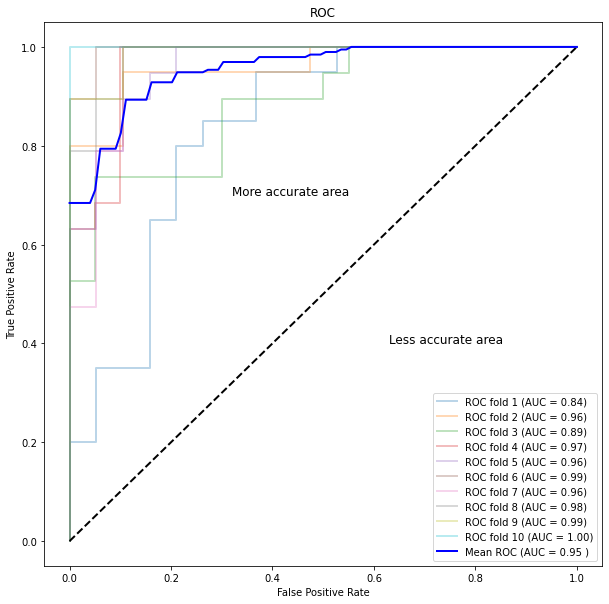

In [195]:
from sklearn.model_selection import StratifiedKFold
x=df_top30
y=y_resampled_2
cv = StratifiedKFold(n_splits=10,shuffle=False)
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(x,y):
    prediction = clf.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1
    
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)
plt.rcParams["figure.figsize"] = (10,10)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

In [171]:
train_4, test_4, train_y_4, test_y_4 = train_test_split(df_top30,y_resampled_2, test_size = 0.3, random_state =21) # traindata, testdata split 비율 7:3
print(train_4.shape, test_4.shape, train_y_4.shape, test_y_4.shape) # 데이터 shape 확인

(268, 30) (116, 30) (268,) (116,)


In [172]:
random_forest_model1 = RandomForestClassifier(n_estimators = 600, # 900번 추정
                                             max_depth = 5, # 트리 최대 깊이 5
                                             random_state = 40) # 시드값 고정
model1 = random_forest_model1.fit(train_4, train_y_4) # 학습 진행
predict1 = model1.predict(test_4) # 평가 데이터 예측
print("Accuracy: %.2f" % (accuracy_score(test_y_4, predict1) * 100), "%") # 정확도 % 계산

Accuracy: 90.52 %


In [173]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,auc
 ##재현율과 정밀도가 비슷할수록 f1 score는 높아짐 (the harmonic mean of recall and precision)
model_metrics = {}
model_metrics['randomforest: Accuracy'] = accuracy_score(test_y_4, predict1) 
model_metrics['randomforest: Precision'] = precision_score(test_y_4, predict1)
model_metrics['randomforest: Recall'] = recall_score(test_y_4, predict1) 
model_metrics['randomforest: F1 score'] =f1_score(test_y_4, predict1) 
model_metrics['randomforest: AUC'] =roc_auc_score(test_y_4,clf.predict_proba(test_4)[:, 1])
pd.DataFrame([model_metrics])

,randomforest: Accuracy,randomforest: Precision,randomforest: Recall,randomforest: F1 score,randomforest: AUC
0,0.905172,0.847458,0.961538,0.900901,0.998798


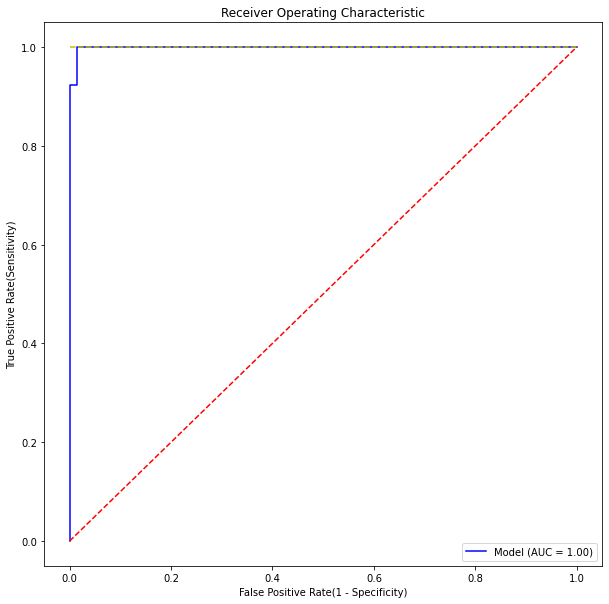

In [196]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y_4, clf.predict_proba(test_4)[:, 1])
roc_auc = roc_auc_score(test_y_4,clf.predict_proba(test_4)[:, 1])
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate(1 - Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate, true_positive_rate, 'b', label='Model (AUC = %0.2f)'% roc_auc)
plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')
plt.rcParams["figure.figsize"] = (10,10)
plt.legend(loc='lower right')
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In [197]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5,criterion="gini",n_estimators=600, random_state=49)
clf.fit(df_top20, y_resampled_2)

RandomForestClassifier(max_depth=5, n_estimators=600, random_state=49)

In [177]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, random_state=68)

In [179]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,auc
from sklearn.model_selection import cross_val_score
model_metrics = {}
from sklearn.utils import shuffle
X_s, y_s = shuffle(df_top20,y_resampled_2,random_state=12)

In [180]:
model_metrics['randomforest cv: Accuracy'] = round(np.mean(cross_val_score(clf,df_top20, y_resampled_2,cv=kfold,n_jobs=1,scoring='accuracy')),3)
model_metrics['randomforest cv: Precision'] =round(np.mean(cross_val_score(clf,df_top20, y_resampled_2,cv=kfold,n_jobs=1,scoring='precision')),3)
model_metrics['randomforest cv: Recall'] = round(np.mean(cross_val_score(clf,df_top20, y_resampled_2,cv=kfold,n_jobs=1,scoring='recall')),3)
model_metrics['randomforest cv: F1 score'] =round(np.mean(cross_val_score(clf,df_top20, y_resampled_2,cv=kfold,n_jobs=1,scoring='f1')),3)
model_metrics['randomforest cv: AUC']= round(np.mean(cross_val_score(clf,X_s, y_s,cv=kfold,n_jobs=1,scoring='roc_auc')),3)
#model_metrics['randomforest cv: AUC'] =round(np.mean(cross_val_score(clf,X_resampled_1, y_resampled_1,cv=kfold,n_jobs=1,scoring='roc_auc')),3)
pd.DataFrame([model_metrics])

,randomforest cv: Accuracy,randomforest cv: Precision,randomforest cv: Recall,randomforest cv: F1 score,randomforest cv: AUC
0,0.84,0.581,0.542,0.561,0.942


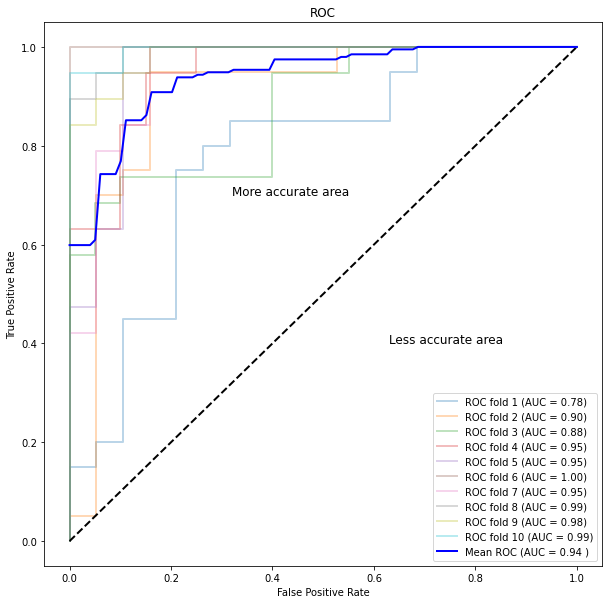

In [198]:
from sklearn.model_selection import StratifiedKFold
x=df_top20
y=y_resampled_2
cv = StratifiedKFold(n_splits=10,shuffle=False)
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(x,y):
    prediction = clf.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1
    
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In [182]:
train_5, test_5, train_y_5, test_y_5 = train_test_split(df_top20,y_resampled_2, test_size = 0.3, random_state =21) # traindata, testdata split 비율 7:3
print(train_5.shape, test_5.shape, train_y_5.shape, test_y_5.shape) # 데이터 shape 확인

(268, 20) (116, 20) (268,) (116,)


In [183]:
random_forest_model1 = RandomForestClassifier(n_estimators = 600, # 900번 추정
                                             max_depth = 5, # 트리 최대 깊이 5
                                             random_state = 40) # 시드값 고정
model1 = random_forest_model1.fit(train_5, train_y_5) # 학습 진행
predict1 = model1.predict(test_5) # 평가 데이터 예측
print("Accuracy: %.2f" % (accuracy_score(test_y_5, predict1) * 100), "%") # 정확도 % 계산

Accuracy: 93.10 %


In [184]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,auc
 ##재현율과 정밀도가 비슷할수록 f1 score는 높아짐 (the harmonic mean of recall and precision)
model_metrics = {}
model_metrics['randomforest: Accuracy'] = accuracy_score(test_y_5, predict1) 
model_metrics['randomforest: Precision'] = precision_score(test_y_5, predict1)
model_metrics['randomforest: Recall'] = recall_score(test_y_5, predict1) 
model_metrics['randomforest: F1 score'] =f1_score(test_y_5, predict1) 
model_metrics['randomforest: AUC'] =roc_auc_score(test_y_5,clf.predict_proba(test_5)[:, 1])
pd.DataFrame([model_metrics])

,randomforest: Accuracy,randomforest: Precision,randomforest: Recall,randomforest: F1 score,randomforest: AUC
0,0.931034,0.866667,1.0,0.928571,0.995192


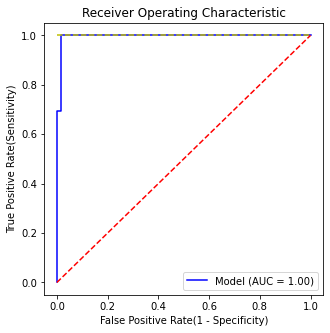

In [191]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y_5, clf.predict_proba(test_5)[:, 1])
roc_auc = roc_auc_score(test_y_5,clf.predict_proba(test_5)[:, 1])
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate(1 - Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate, true_positive_rate, 'b', label='Model (AUC = %0.2f)'% roc_auc)
plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')
plt.rcParams["figure.figsize"] = (10,10)
plt.legend(loc='lower right')
plt.show()

In [199]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5,criterion="gini",n_estimators=600, random_state=49)
clf.fit(df_top10, y_resampled_2)

RandomForestClassifier(max_depth=5, n_estimators=600, random_state=49)

In [200]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, random_state=68)

In [201]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,auc
from sklearn.model_selection import cross_val_score
model_metrics = {}
from sklearn.utils import shuffle
X_s, y_s = shuffle(df_top10,y_resampled_2,random_state=12)

In [203]:
model_metrics['randomforest cv: Accuracy'] = round(np.mean(cross_val_score(clf,df_top10, y_resampled_2,cv=kfold,n_jobs=1,scoring='accuracy')),3)
model_metrics['randomforest cv: Precision'] =round(np.mean(cross_val_score(clf,df_top10, y_resampled_2,cv=kfold,n_jobs=1,scoring='precision')),3)
model_metrics['randomforest cv: Recall'] = round(np.mean(cross_val_score(clf,df_top10, y_resampled_2,cv=kfold,n_jobs=1,scoring='recall')),3)
model_metrics['randomforest cv: F1 score'] =round(np.mean(cross_val_score(clf,df_top10, y_resampled_2,cv=kfold,n_jobs=1,scoring='f1')),3)
model_metrics['randomforest cv: AUC']= round(np.mean(cross_val_score(clf,X_s, y_s,cv=kfold,n_jobs=1,scoring='roc_auc')),3)
#model_metrics['randomforest cv: AUC'] =round(np.mean(cross_val_score(clf,X_resampled_1, y_resampled_1,cv=kfold,n_jobs=1,scoring='roc_auc')),3)
pd.DataFrame([model_metrics])

,randomforest cv: Accuracy,randomforest cv: Precision,randomforest cv: Recall,randomforest cv: F1 score,randomforest cv: AUC
0,0.783,0.561,0.525,0.54,0.92


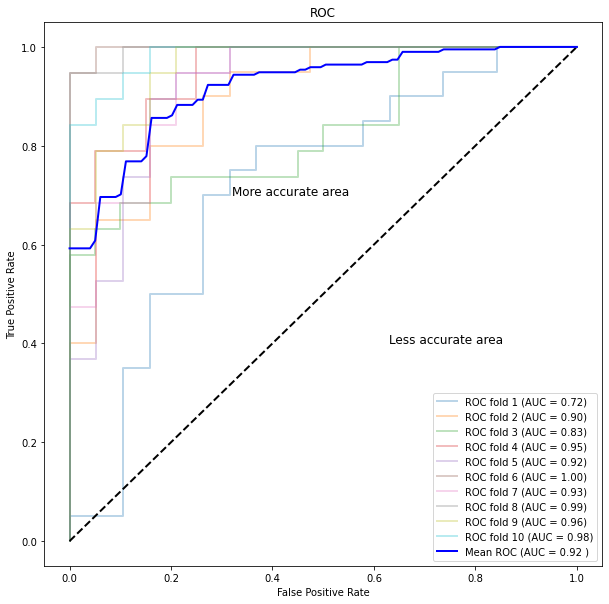

In [204]:
from sklearn.model_selection import StratifiedKFold
x=df_top10
y=y_resampled_2
cv = StratifiedKFold(n_splits=10,shuffle=False)
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(x,y):
    prediction = clf.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1
    
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In [205]:
train_6, test_6, train_y_6, test_y_6 = train_test_split(df_top10,y_resampled_2, test_size = 0.3, random_state =21) # traindata, testdata split 비율 7:3
print(train_6.shape, test_6.shape, train_y_6.shape, test_y_6.shape) # 데이터 shape 확인

(268, 10) (116, 10) (268,) (116,)


In [206]:
random_forest_model1 = RandomForestClassifier(n_estimators = 600, # 900번 추정
                                             max_depth = 5, # 트리 최대 깊이 5
                                             random_state = 40) # 시드값 고정
model1 = random_forest_model1.fit(train_6, train_y_6) # 학습 진행
predict1 = model1.predict(test_6) # 평가 데이터 예측
print("Accuracy: %.2f" % (accuracy_score(test_y_6, predict1) * 100), "%") # 정확도 % 계산

Accuracy: 85.34 %


In [207]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,auc
 ##재현율과 정밀도가 비슷할수록 f1 score는 높아짐 (the harmonic mean of recall and precision)
model_metrics = {}
model_metrics['randomforest: Accuracy'] = accuracy_score(test_y_6, predict1) 
model_metrics['randomforest: Precision'] = precision_score(test_y_6, predict1)
model_metrics['randomforest: Recall'] = recall_score(test_y_6, predict1) 
model_metrics['randomforest: F1 score'] =f1_score(test_y_6, predict1) 
model_metrics['randomforest: AUC'] =roc_auc_score(test_y_6,clf.predict_proba(test_6)[:, 1])
pd.DataFrame([model_metrics])

,randomforest: Accuracy,randomforest: Precision,randomforest: Recall,randomforest: F1 score,randomforest: AUC
0,0.853448,0.79661,0.903846,0.846847,0.992788


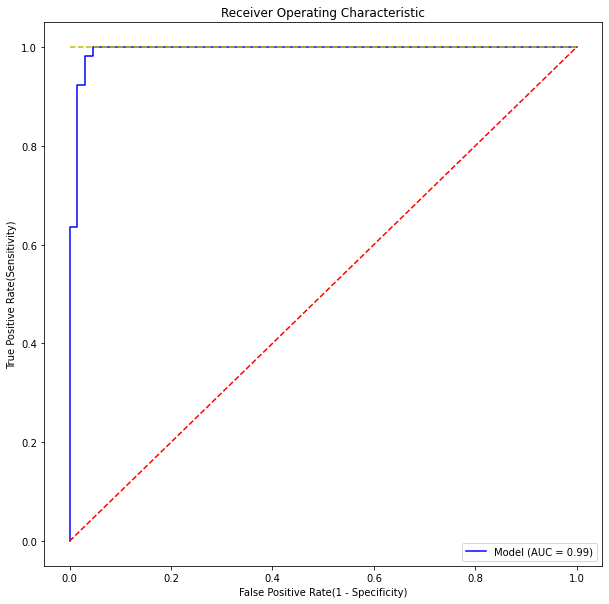

In [210]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y_6, clf.predict_proba(test_6)[:, 1])
roc_auc = roc_auc_score(test_y_6,clf.predict_proba(test_6)[:, 1])
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate(1 - Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate, true_positive_rate, 'b', label='Model (AUC = %0.2f)'% roc_auc)
plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')
plt.rcParams["figure.figsize"] = (10,10)
plt.legend(loc='lower right')
plt.rcParams["figure.figsize"] = (10,10)
plt.show()

In [202]:
train_2, test_2, train_y_2, test_y_2 = train_test_split(X_resampled_2,y_resampled_2, test_size = 0.3, random_state =21) # traindata, testdata split 비율 7:3
print(train_2.shape, test_2.shape, train_y_2.shape, test_y_2.shape) # 데이터 shape 확인

(268, 144) (116, 144) (268,) (116,)


In [123]:
random_forest_model1 = RandomForestClassifier(n_estimators = 600, # 900번 추정
                                             max_depth = 5, # 트리 최대 깊이 5
                                             random_state = 40) # 시드값 고정
model1 = random_forest_model1.fit(train_2, train_y_2) # 학습 진행
predict1 = model1.predict(test_2) # 평가 데이터 예측
print("Accuracy: %.2f" % (accuracy_score(test_y_2, predict1) * 100), "%") # 정확도 % 계산

Accuracy: 91.38 %


In [124]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,auc
 ##재현율과 정밀도가 비슷할수록 f1 score는 높아짐 (the harmonic mean of recall and precision)
model_metrics = {}
model_metrics['randomforest: Accuracy'] = accuracy_score(test_y_2, predict1) 
model_metrics['randomforest: Precision'] = precision_score(test_y_2, predict1)
model_metrics['randomforest: Recall'] = recall_score(test_y_2, predict1) 
model_metrics['randomforest: F1 score'] =f1_score(test_y_2, predict1) 
model_metrics['randomforest: AUC'] =roc_auc_score(test_y_2,clf.predict_proba(test_2)[:, 1])
pd.DataFrame([model_metrics])

,randomforest: Accuracy,randomforest: Precision,randomforest: Recall,randomforest: F1 score,randomforest: AUC
0,0.913793,0.85,0.980769,0.910714,1.0


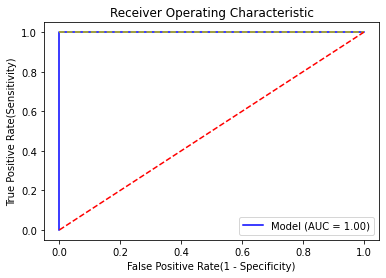

In [125]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y_2, clf.predict_proba(test_2)[:, 1])
roc_auc = roc_auc_score(test_y_2,clf.predict_proba(test_2)[:, 1])
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate(1 - Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate, true_positive_rate, 'b', label='Model (AUC = %0.2f)'% roc_auc)
plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')

plt.legend(loc='lower right')
plt.show()

In [126]:
# 모델설정
sm=SMOTE(random_state=0)
# train데이터를 넣어 복제함
X_resampled_3, y_resampled_3 = sm.fit_sample(bohun_train_3,bohun_y_train_1)

Class=1, n=192 (50.000%)
Class=0, n=192 (50.000%)


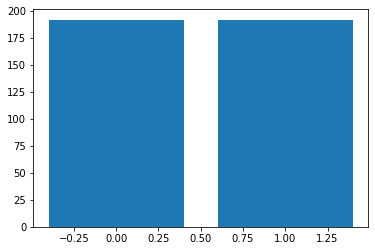

In [127]:
count_and_plot(y_resampled_3)

In [129]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=5,criterion="gini",n_estimators=600, random_state=49)
clf.fit(X_resampled_3, y_resampled_3)

RandomForestClassifier(max_depth=5, n_estimators=600, random_state=49)

In [130]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=10, random_state=68)

In [131]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,auc
from sklearn.model_selection import cross_val_score
model_metrics = {}

In [132]:
from sklearn.utils import shuffle
X_s, y_s = shuffle(X_resampled_3,y_resampled_3,random_state=12)

In [133]:
model_metrics['randomforest cv: Accuracy'] = round(np.mean(cross_val_score(clf,X_resampled_3, y_resampled_3,cv=kfold,n_jobs=1,scoring='accuracy')),3)
model_metrics['randomforest cv: Precision'] =round(np.mean(cross_val_score(clf,X_resampled_3, y_resampled_3,cv=kfold,n_jobs=1,scoring='precision')),3)
model_metrics['randomforest cv: Recall'] = round(np.mean(cross_val_score(clf,X_resampled_3, y_resampled_3,cv=kfold,n_jobs=1,scoring='recall')),3)
model_metrics['randomforest cv: F1 score'] =round(np.mean(cross_val_score(clf,X_resampled_3, y_resampled_3,cv=kfold,n_jobs=1,scoring='f1')),3)
model_metrics['randomforest cv: AUC']= round(np.mean(cross_val_score(clf,X_s, y_s,cv=kfold,n_jobs=1,scoring='roc_auc')),3)
#model_metrics['randomforest cv: AUC'] =round(np.mean(cross_val_score(clf,X_resampled_1, y_resampled_1,cv=kfold,n_jobs=1,scoring='roc_auc')),3)
pd.DataFrame([model_metrics])

,randomforest cv: Accuracy,randomforest cv: Precision,randomforest cv: Recall,randomforest cv: F1 score,randomforest cv: AUC
0,0.814,0.567,0.56,0.562,0.943


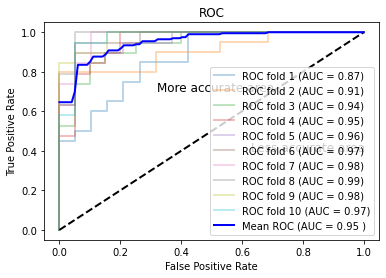

In [134]:
from sklearn.model_selection import StratifiedKFold
x=X_resampled_3
y=y_resampled_3
cv = StratifiedKFold(n_splits=10,shuffle=False)
tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)
i = 1
for train,test in cv.split(x,y):
    prediction = clf.fit(x.iloc[train],y.iloc[train]).predict_proba(x.iloc[test])
    fpr, tpr, t = roc_curve(y[test], prediction[:, 1])
    tprs.append(np.interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
    i= i+1
    
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.2f )' % (mean_auc),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.text(0.32,0.7,'More accurate area',fontsize = 12)
plt.text(0.63,0.4,'Less accurate area',fontsize = 12)
plt.show()

In [135]:
train_3, test_3, train_y_3, test_y_3 = train_test_split(X_resampled_3,y_resampled_3, test_size = 0.3, random_state =2) # traindata, testdata split 비율 7:3
print(train_3.shape, test_3.shape, train_y_3.shape, test_y_3.shape) # 데이터 shape 확인

(268, 72) (116, 72) (268,) (116,)


In [136]:
random_forest_model1 = RandomForestClassifier(n_estimators = 600, # 900번 추정
                                             max_depth = 5, # 트리 최대 깊이 5
                                             random_state = 40) # 시드값 고정
model1 = random_forest_model1.fit(train_3, train_y_3) # 학습 진행
predict1 = model1.predict(test_3) # 평가 데이터 예측
print("Accuracy: %.2f" % (accuracy_score(test_y_3, predict1) * 100), "%") # 정확도 % 계산

Accuracy: 87.07 %


In [137]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,auc
 ##재현율과 정밀도가 비슷할수록 f1 score는 높아짐 (the harmonic mean of recall and precision)
model_metrics = {}
model_metrics['randomforest: Accuracy'] = accuracy_score(test_y_3, predict1) 
model_metrics['randomforest: Precision'] = precision_score(test_y_3, predict1)
model_metrics['randomforest: Recall'] = recall_score(test_y_3, predict1) 
model_metrics['randomforest: F1 score'] =f1_score(test_y_3, predict1) 
model_metrics['randomforest: AUC'] =roc_auc_score(test_y_3,clf.predict_proba(test_3)[:, 1])
pd.DataFrame([model_metrics])

,randomforest: Accuracy,randomforest: Precision,randomforest: Recall,randomforest: F1 score,randomforest: AUC
0,0.87069,0.83871,0.912281,0.87395,1.0


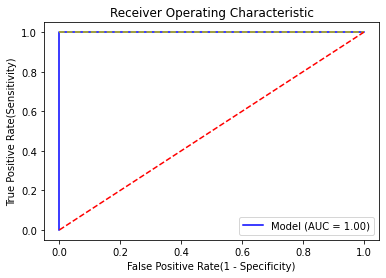

In [138]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(test_y_3, clf.predict_proba(test_3)[:, 1])
roc_auc = roc_auc_score(test_y_3,clf.predict_proba(test_3)[:, 1])
plt.title('Receiver Operating Characteristic')
plt.xlabel('False Positive Rate(1 - Specificity)')
plt.ylabel('True Positive Rate(Sensitivity)')

plt.plot(false_positive_rate, true_positive_rate, 'b', label='Model (AUC = %0.2f)'% roc_auc)
plt.plot([0,1],[1,1],'y--')
plt.plot([0,1],[0,1],'r--')

plt.legend(loc='lower right')
plt.show()